# 2. Phase transitions and the Ising model

The Ising model is probably the most studied model of
ferromagnetism and phase transitions in general.
In the model, a set of spins $s_i= \pm 1$ reside
on the site of a $d$-dimensional lattice. The energy (or Hamiltonian) associated  with a configuration of spins $s_i$ is given by
\begin{equation}
\mathcal{H}= -J \sum_{\langle i,j \rangle} s_i s_j -H \sum_i s_i,
\label{eq:ising_model}
\end{equation}
where $J>1$ is the ferromagnetic coupling, favoring parallel
spins, and $H$ is the external magnetic field (in suitable units).
The first sum in the energy is restricted to
nearest-neighbor pairs. The Ising model can be solved exactly
in $d=2$ (for $H=0$) and displays a second-order phase transition
at a critical temperature $T_c$. Here we will study the model with Monte-Carlo simulations


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from scipy.optimize import curve_fit
%matplotlib inline

In [ ]:
import matplotlib as mpl
import random
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

# 2.A Monte Carlo simulations

In this exercise, we focus on the case $J=1, H=0$, that is, a ferromagnetic system with no external field. Remember that the sum $\langle ij \rangle$ runs over neighbouring sites only. In our 2D lattice, each site has 4 neighbours.

<img src="attachment:image.png" width="250">


We will work with **periodic boundary conditions**, so that all spins have 4 neighbours.

<img src="attachment:image.png" width="250">


# The Metropolis algorithm
We will build a simple implementation of the **Metropolis** algorithm for the 2D Ising model.

As a reminder, a single update of the Metropolis algorithm works as follows:

1. Pick a site $(i, j)$ at random.
2. Calculate the energy change $\Delta E$ that flipping the spin $s_{ij}$ would produce.
3. If $\Delta E <0$, flip the spin with probability $1$.
4. If $\Delta E >0$, flip the spin with probability $e^{-\beta \Delta E}$.

### Exercice 2.1
Write a function that, given an integer $N$, returns an $N \times N$ array whose elements are randomly picked from {-1, 1}.

In [ ]:
def create_initial_config(N=None):
    """
    Create the starting initial configuration.

    All elements are {-1, 1} with 50% prob.
    The lattice is a square of size N.

    Parameters
    ----------
    N : int
        The system size.

    Returns
    -------
    config : np.array, (N, N)
        A random {-1, 1} array of size (N, N).
    """
    config = np.zeros((N, N))
    for i in range(N):
      for j in range(N):
        choice = random.choice([-1, 1])
        config[i][j] = choice
    return config

Let us create an initail configuration with our `create_inital_config_function`. A system size of $N=100$ will be enough.

In [ ]:
config = create_initial_config(N=100)

To plot our system we can use `plt.imshow()`, as follows:

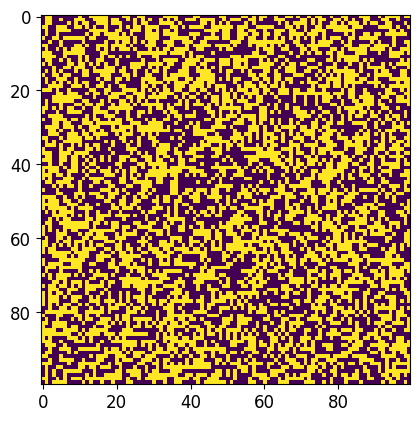

In [ ]:
plt.imshow(config);

### Exercise 2.2
We will write our Metropolis update function. Given a site $(i, j)$, what is the change in energy $\Delta E$ that flipping $S(i, j)$ entails?
Recall that only 4 spins are connected to $(i, j)$, so you don't need to compute the energy of the whole system.

*   If the spin goes from up to down $E_-$ - $E_+$= 2J$m_i$ + 2H
*   If the spin goes from down to up $E_+$ - $E_-$= -2J$m_i$ - 2H

Where  $m_i=$


*   4 (4 neighbors up)
*   2 (3 neighbors up)
*   0 (2 neighbors up)
*   -2 (1 neighbors up)
*   -4 (0 neighbors up)






### Exercise 2.3
Write a function called `metropolis_single_update()`.  
The **input** should be:

+ *config*, a lattice configuration as an (N, N) array.
+ *T*, the temperatue.

There is no need to return anything since in python, functions can modify its input, so we will be updating config *inplace*. But it is useful to return the energy change $\Delta E$ if one later wants to track the energy during simulations. To simplify things, we will use **periodic boundary conditions** (in python, the modulo operator is `%`).

In [ ]:
def metropolis_single_update(config=None, T=None):
    '''
    Do a single Monte Carlo update using Metropolis algorithm.

    Parameters
    ----------
    config : np.array, (N, N)
        The current configuration.
    T : float
        The temperature.

    '''
    # make sure config is square
    N, M = config.shape
    assert N == M

    # choose random site
    i = random.randint(0, N-1)
    j = random.randint(0, N-1)
    s =  config[i][j]

    # compute energy cost of flip
    # DeltaE is the possible energy cost
    # effDeltaE is the real energy cost (depending on whether we did the flip or not)
    DeltaE = 0

    left_i = (i - 1) % N
    right_i = (i + 1) % N
    up_j = (j - 1) % N
    down_j = (j + 1) % N

    DeltaE += 2 * s * (config[left_i][j] + config[right_i][j] + config[i][up_j] + config[i][down_j])


    effDeltaE = 0

    # case DeltaE < 0, flip the spin with prob 1
    if DeltaE < 0:
        # flip the sping
        s *= -1
        # set effective DeltaE to DeltaE
        effDeltaE = DeltaE

    # case DeltaE >= 0
    else:
        # flip the spin with certain probability
        P = random.random()
        exp_p = np.exp(-DeltaE/T)
        if P <= exp_p:
            # flip the sping
            s *= -1
            # set effective Delta E
            effDeltaE = DeltaE

    # update configuration
    # notice there is no need to return the whole configuration, the function
    # will modify config _in_place_
    config[i, j] = s

    # but it is clever to return the effective DeltaE, since we have already computed it
    # notice that if we didn't flip the spin, the change in energy is 0
    return effDeltaE

In [ ]:
metropolis_single_update(config, 30.5)

4.0

## Visualizing the simulation on real time
To see if our Metropolis algorithm works, you might want to simulate systems at different temperatures, and observe how the configuration evolves trought time. To do this you need the `display` module. Below you will find an example of how to use it.

For the 2D Ising model, the **critical temperature** is known to be
$$
T_c = \frac{2}{\ln(1+\sqrt{2})} \simeq 2.2691853...
$$
(with $k_B=1$). Try executing the cell below at different values of the temperature, for different system size.

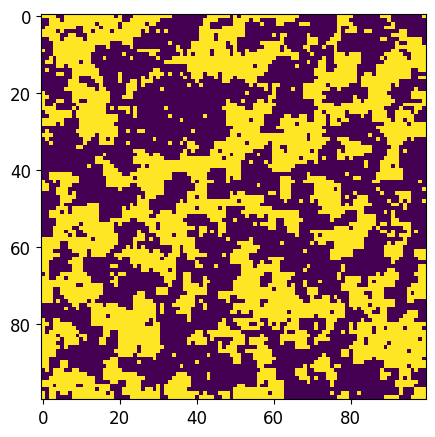

In [ ]:
T_c = 2/np.log(1+np.sqrt(2))

# create initial random configuration
config = create_initial_config(N=100)

# set up figure, plot first frame
fig, ax = plt.subplots(1, 1, figsize=(6,5))
# draw the initial configuration,
# naming the plot "im".
im = ax.imshow(config)

for t in range(100000):
    # update the system
    DeltaE = metropolis_single_update(config, T=T_c)
    # replot every 1000 MC updates
    if t%1000==0:
        # update the data of the plot (not the whole figure!)
        im.set_data(config)
        # rerender
        display.display(plt.gcf())
        display.clear_output(wait=True)

### Exercice 2.4
Write a function that computes the energy of a configuration, and another that tracks its evolution over time.
$E = -\sum_{(a, b)} S_a S_b$,

In [ ]:
def get_energy(config):
    """
    Compute the energy of a configuration.

    The energy is defined as $E = -\sum_{(a, b)} S_a S_b$,
    where the sum runs over pairs of adjacent spins.

    Parameters
    ----------
    config : np.array, (N, N)
        The system configuration.


    Returns
    -------
    E : float
        The energy of the configuration.
    """
    N = len(config)
    # list of pairs of adjacent sites as four-element tuples:
    # (i1, j1, i2, j2) represents two adjacent sites located
    # at (i1, j1) and (i2, j2)
    horizontal_edges = [
        (i, j, i, j+1)
        for i in range(N) for j in range(N-1)
    ]
    vertical_edges = [
         (i, j, i+1, j)
        for i in range(N-1) for j in range(N)
    ]
    # summing lists in python concatenates them
    # [1, 2, 3] + [4, 5] = [1, 2, 3, 4, 5]
    edges = horizontal_edges + vertical_edges
    E = 0
    for i1, j1, i2, j2 in edges:
        E -= 2*config[i1][j1] * config[i2][j2]

    return E

In [ ]:
get_energy(config)

-23204.0

In [ ]:
def get_energy_evolution(N=20, T=T_c, n_updates=50000):
    """
    Compute the energy evolution of a 2D Ising instance.

    Parameters
    ----------
    N : int
        The system size.
    T : float
        The temperature.
    n_updates : int
        Number of Metropolis updates.

    Returns
    -------
    Es : np.array, (n_updates, )
    """
    config = create_initial_config(N)
    Es = np.zeros(n_updates)
    for i in range(n_updates):
      metropolis_single_update(config, T)
      get_energy(config)
      Es[i] = get_energy(config)
    return Es

### Exercise 2.5
Compute the energy of your system during a long simulation, and plot it as a function of time. **Tip** Use logarithmic x-axis!

In [ ]:
energy_evolution = get_energy_evolution(20,T_c,100000)

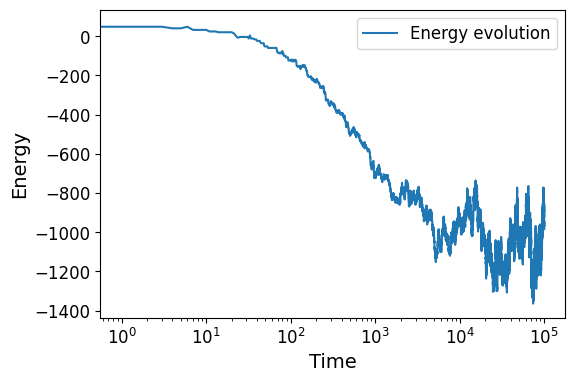

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.semilogx(energy_evolution, label="Energy evolution")

ax.set_xlabel("Time")
ax.set_ylabel("Energy")
ax.legend()

### Exercise 2.6
Can you distinguish two qualitatively different periods? What do they correspond to?

After a first period of descending, the energy oscillates around a value of equilibrium, if N=20 at critical temperature, this change happens around $10^4$.

## Magnetization
We will now compute the magnetization $M$ as a function of the temperature $T$.

### Exercise 2.7
Write a function that computes the magnetization of a 2D Ising system after certain equilibration period.

In [ ]:
def calculate_magnetization(system_size=None, temperature=None, equilibration_time=None):
    """
    Calculate the magnetization of a 2D Ising model.

    Parameters
    ----------
    system_size : int
        The lattice size.
    temperature : float
        The simulation temperature.
    equilibration_time : int
        Number of sweeps before measuring M.

    """
    # instantiate model
    config = create_initial_config(system_size)
    # equilibrate
    for i in range(equilibration_time):
      metropolis_single_update(config, temperature)
    # compute magnetization
    m = 0
    m = sum(sum(config))
    return m/(system_size*system_size)


In [ ]:
calculate_magnetization(2, T_c, 100)

1.0

### Exercise 2.8
+ Compute the magnetization for a system of size $N=64$, for diverent values of $T\in[1.5, 3.5]$.
+ Remember to choose wisely the equilibration time!
+ Plot $|M|$ as a function of $T$, and mark the critical temperature in your plot using the `plt.axvline()` function.

In [ ]:
# define range of temperatures
temperatures = np.linspace(1.5, 3.5, num=100)
# system size
system_size = 64
# equilibration time
equilibration_time = 350000

# loop over temperatures, compute magnetizations
magnetizations = []
for temperature in temperatures:
    magnetization = calculate_magnetization(system_size, temperature, equilibration_time)
    magnetizations.append(abs(magnetization))

Text(0, 0.5, 'Magnetization')

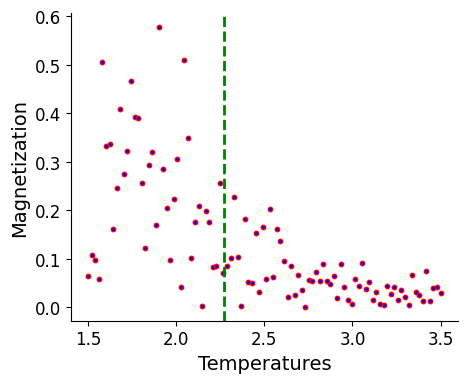

In [ ]:
# define critical temperature
T_c = 2/np.log(1+np.sqrt(2))

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.scatter(
    temperatures, magnetizations,
    # style keywords
    edgecolors='r', color='b', s=10
)
ax.axvline(
    T_c,
    # style keywords
    c='green', lw=2, ls='--'
)
#ax.set_title('mag as t')
ax.set_xlabel('Temperatures')
ax.set_ylabel('Magnetization')

# Finding clusters
Given an Ising configuration, we define a cluster of spins as a set of neighbouring spins of the same sign surrounded by spins of the opposite sign.

<img src="attachment:image.png" width="600">

### Exercise 2.9
The formal definition of cluster is very clear, but in practice, how do you find (*efficiently* if possible) all clusters for a given configuration? We need to assign a **unique cluster label** to each spin. The cluster label could be anything (a color, a letter, a number...), it just needs to be the same for all spins that belong to the same cluster. For simplicity, we will use integers.

Think about an algorithm that assigns unique cluster labels to spins. Explain your algorithm in simple words / steps / pseudocode.

Remember:
+ Clusters can trespass (periodic) boundary conditions
+ Both `+1`'s and `-1`'s can form clusters!

The algorithm find all clusters in the following way:


1. The dimension of the configuration input is extracted, in order to define the labels np.array with the same dimensions.
2. The algorithm starts from the first element to find the clusters by assigning to it a label.
3. The algorithm then explore on the right of the starting element and assign to every element with the same spin value the same label of the starting point.
4. The algotrithm stops the search on the right in the moment that a different value is found.
5. After the first stop, the algorithm starts again its search, but this time by exploring the value on the bottom.
6. It continues until the all config array is explored.
7. When no more clusters are found, it then calls another function that renames all the clusters.



### Exercise 2.10
Write a function that, given a configuration array `config`, returns another array `labels` where each cluster has a different label.

<img src="attachment:image.png" width="600">

Remember:
+ Clusters can trespass (periodic) boundary conditions
+ Both `+1`'s and `-1`'s can form clusters!


In [ ]:
def relabel_clusters(labels):
    unique_labels = np.unique(labels)
    relabel_map = {label: idx for idx, label in enumerate(unique_labels)}
    relabeled_labels = np.vectorize(relabel_map.get)(labels)
    return relabeled_labels

In [ ]:
def get_labels(config):
    """
    Get unique cluster labels with periodic boundary conditions.

    Parameters
    ----------
    config : np.array, (N, N)
        Configuration of the system in {-1, 1} notation
    Returns
    -------
    labels : np.array, (N, N)
        Labels that identify the clusters
    """
    N = len(config)
    labels = np.zeros((N, N), dtype=int)
    current_label = 1

    for i in range(N):
        for j in range(N):
            if labels[i][j] == 0:
                labels[i][j] = current_label
                current_label += 1

            # Check right neighbor
            if config[i][j] == config[i][(j + 1) % N]:
                if labels[i][(j + 1) % N] == 0:
                    labels[i][(j + 1) % N] = labels[i][j]
                else:
                    labels[labels == labels[i][(j + 1) % N]] = labels[i][j]

            # Check bottom neighbor
            if config[i][j] == config[(i + 1) % N][j]:
                if labels[(i + 1) % N][j] == 0:
                    labels[(i + 1) % N][j] = labels[i][j]
                else:
                    labels[labels == labels[(i + 1) % N][j]] = labels[i][j]

    return relabel_clusters(labels)

### Test your function
To help you **test** your function, I have prepared some test data, so that we can all try our algorithms using the same input.

In [ ]:
config_test_0 = np.array([[ 1,  1,  1],
                          [-1, -1,  1],
                          [-1, -1,  1]])

In [ ]:
config_test_1 = np.array([[ 1, -1, -1,  1, -1,  1],
                          [-1, -1, -1,  1, -1,  1],
                          [-1,  1, -1, -1, -1,  1],
                          [-1,  1, -1,  1,  1,  1],
                          [-1,  1, -1, -1,  1, -1],
                          [-1, -1, -1,  1,  1,  1]])

In [ ]:
config_test_2 = np.array([[ 1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [-1, -1, -1,  1,  1, -1, -1, -1,  1, -1],
                          [ 1, -1,  1, -1, -1, -1,  1,  1, -1,  1],
                          [ 1, -1,  1,  1,  1, -1,  1, -1,  1, -1],
                          [-1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [ 1, -1, -1, -1,  1, -1,  1,  1, -1,  1],
                          [-1,  1, -1,  1,  1, -1, -1, -1,  1,  1],
                          [-1, -1, -1, -1,  1,  1, -1, -1, -1,  1],
                          [ 1,  1, -1, -1,  1, -1,  1,  1,  1,  1],
                          [ 1,  1, -1, -1, -1,  1,  1,  1,  1, -1]])


Execute the following cell to make sure your function works correctly. The left column will show the test configurations, and the right column will show the clusters your function found, with different clusters colored in different colors

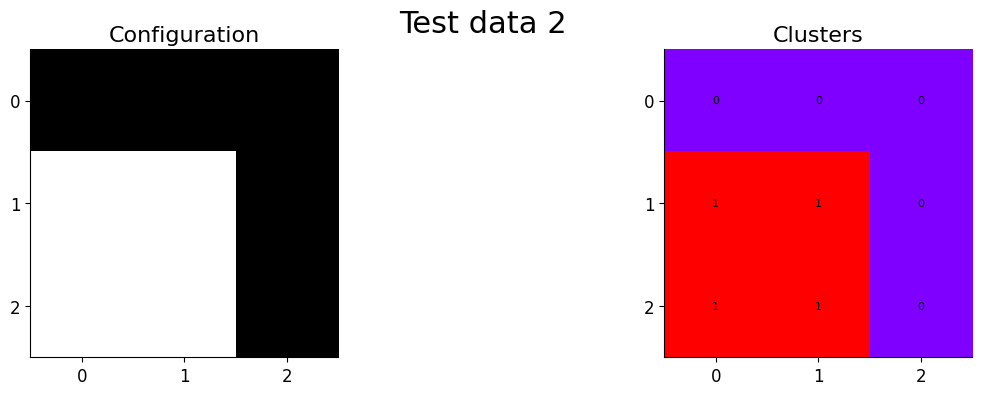

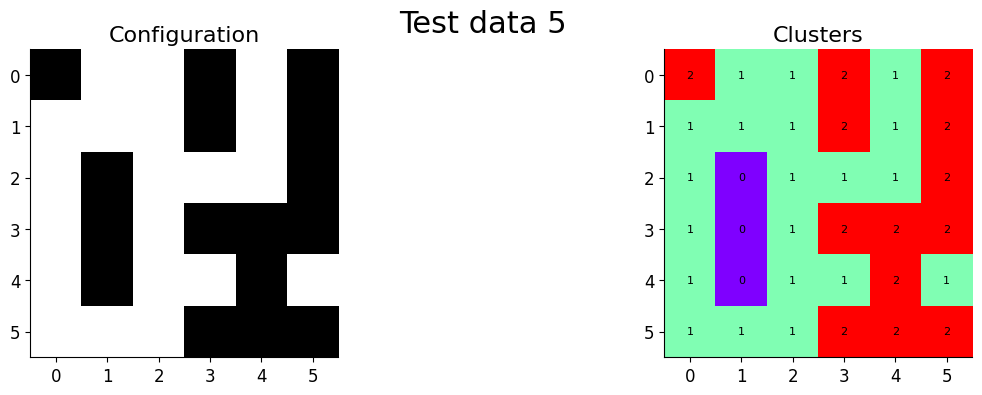

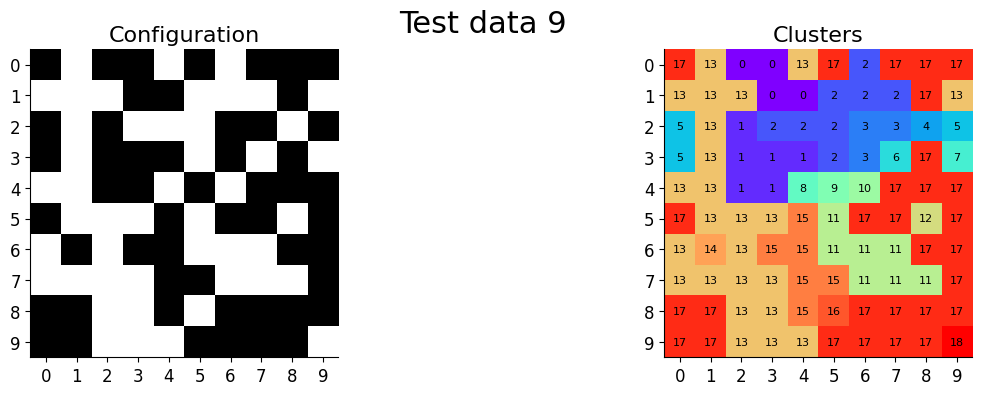

In [ ]:
for i, config in enumerate([config_test_0, config_test_1, config_test_2]):
    labels = get_labels(config)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
    ax1.set_xticks(range(len(config)))
    ax1.set_yticks(range(len(config)))
    ax2.set_xticks(range(len(config)))
    ax2.set_yticks(range(len(config)))
    ax1.set_title("Configuration")
    ax2.set_title("Clusters")
    ax1.imshow(config, cmap="Greys")
    ax2.imshow(labels, cmap="rainbow", )
    unique_labels = np.unique(labels)
    for i in range(len(config)):
        for j in range(len(config)):
            ax2.text(j, i, labels[i, j], ha="center", va="center", color="black", fontsize=8)
    fig.suptitle(f"Test data {i}", fontsize=22)

If your function doesn't work, you might want to use this cell to inspect your results

<Axes: >

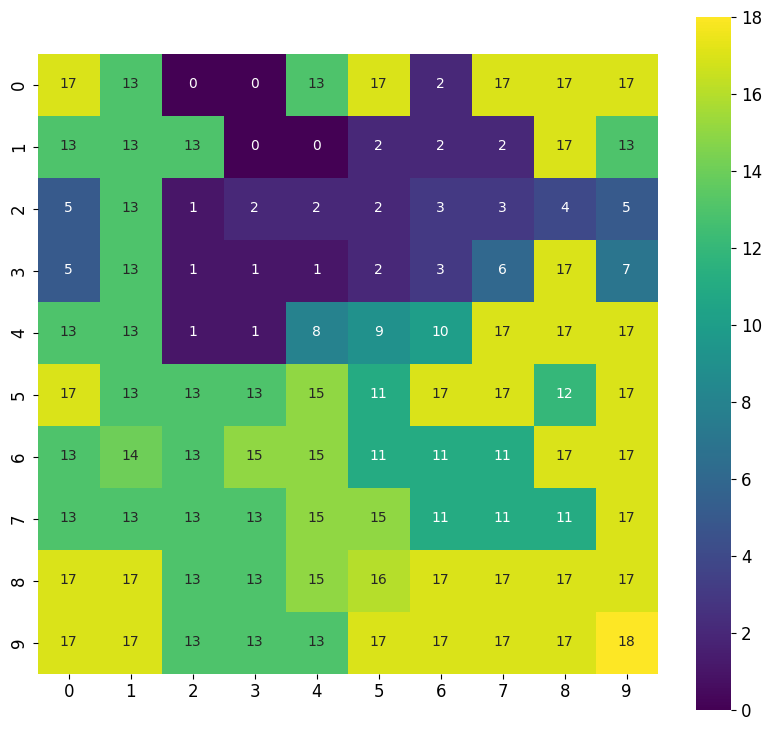

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 9))
ax.set_aspect(1)
sns.heatmap(labels, annot=True, ax=ax, cmap="viridis")

### Measuring cluster sizes
Use your `get_labels()` function to find clusters in a large Ising model, say $N=500$. You can use your own Ising implementation. If you use Sethna's code, remember that he uses $s \in \{0, 1\}$ spins!

In [ ]:
config = create_initial_config(500)
labels = get_labels(config)

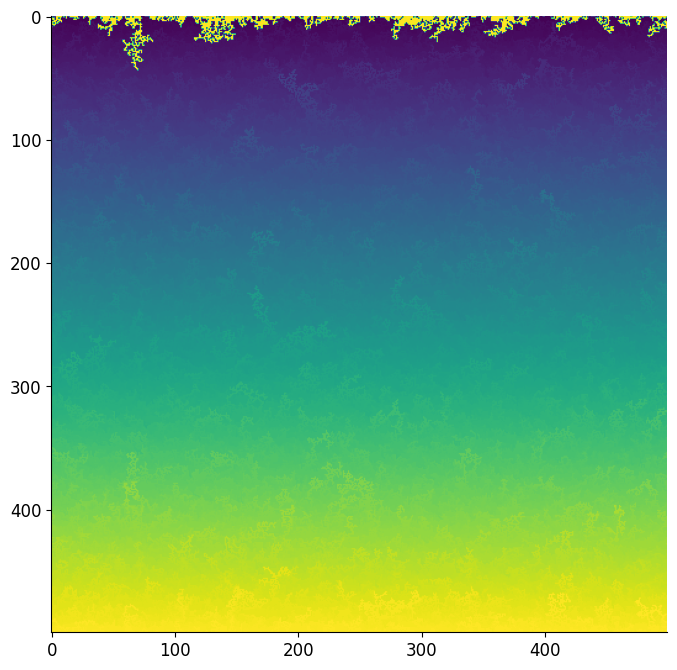

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(labels)

### Exercise 2.11
Find an efficient way to measure cluster sizes. Remind that all you care about is the distribution of cluster sizes, their location does not matter. You might want to use the `.reshape()` method of a numpy array, and the `Counter` class from the `collections` package.

In [ ]:
from collections import Counter

def get_sizes(labels):
    flattened_labels = labels.reshape(-1)
    label_counts = Counter(flattened_labels)
    sizes = np.array(list(label_counts.values()))
    return sizes

In [ ]:
get_sizes(labels)

array([174,  12,  28, ...,   1,   1,   1])

### Exercise 2.12
For $T >> T_c$, spins are essentially uncorrelated. What is the distribution of cluster sizes you expect to find in this case? **Hint** Think about the 1D case assuming totally uncorrelated spins.

If the spins are uncorrelated, basically we can expect that in the 1D case the spins' values would alternate, so there would be more clusters with small size than clusters with large size.

### Exercice 2.13
Do a simulation at very high temperature and measure the cluster size distribution. Plot your results in log-log scale. Do your results agree with your previous answer?

Yes, it does. There are more clusters with a small size than clusters with a large size.

In [ ]:
config = create_initial_config(N=200)
for t in range(100000):
    DeltaE = metropolis_single_update(config, T=5000)
labels = get_labels(config)
sizes = get_sizes(labels)

Text(0, 0.5, 'Frequency of cluster sizes')

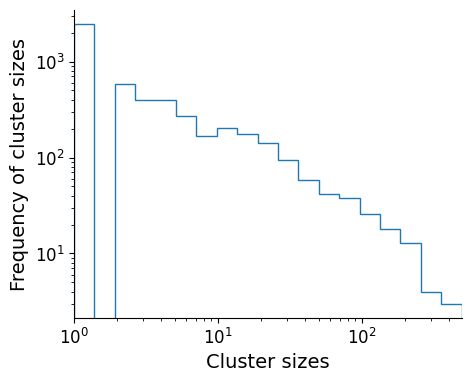

In [ ]:
# use logarithmic bins and logarithmic axes!
bins = np.geomspace(min(sizes), max(sizes), num=20)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(sizes, bins=bins, histtype="step")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(min(sizes), max(sizes))
ax.set_xlabel("Cluster sizes")
ax.set_ylabel("Frequency of cluster sizes")

### Exercise 2.14

At $T_c$, the distribution of cluster sizes is known to be a power law with exponent close to $\alpha \simeq 2$.

$$
P(s) \propto s^{-\alpha}
$$

Do a simulation at $T=T_c$ and compare the resulting cluster size distribution with that obtained at $T>>T_c$.

In [ ]:
# do simulation
T_c = 2/np.log(1+np.sqrt(2))
config2 = create_initial_config(N=200)
for t in range(100000):
  metropolis_single_update(config2, T=T_c)
labels2 = get_labels(config2)
sizes2 = get_sizes(labels2)
def power_law(s, alpha):
    return s**(-alpha)

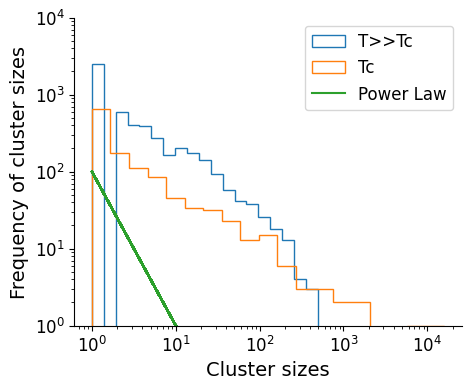

In [ ]:
bins = np.geomspace(min(sizes), max(sizes), num=20)
bins2 = np.geomspace(min(sizes2), max(sizes2), num=20)
power_law = 100*np.power((1/sizes2), 2) #not fitted data

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(sizes, bins=bins, histtype="step",label="T>>Tc")
ax.hist(sizes2, bins=bins2, histtype="step", label="Tc")
ax.plot(sizes2, power_law, label="Power Law")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1, 10000)
ax.set_xlabel("Cluster sizes")
ax.set_ylabel("Frequency of cluster sizes")
ax.legend()

# 2. B Domain corsening dynamics
In the part above we concentrated on the study of the equilibrium properties of the Ising model. We will now study how the model reaches equilibrium when it is "quenched" from the disordered phase into the ordered phase.

Start the sample from a random spin configuration,  then run briefly at H = 0 and $T \gg T_c$. Now set $T\ll T_c$ and observe the dynamics describeing how the domain patterns changes with time.

    measuring on the screen by eye,
    by writing a subroutine to measure correlation functions and finding the half-maximum, or
     (valid only at low temperature),

find the typical size L(t) of the red and white domains, and graph it versus time. What power law do we expect it to grow with? Does it grow as expected? When do finite-size effects start changing things?



### Exercise 2.15
Plot snapshots of the configurations at different times to show the dynamics.


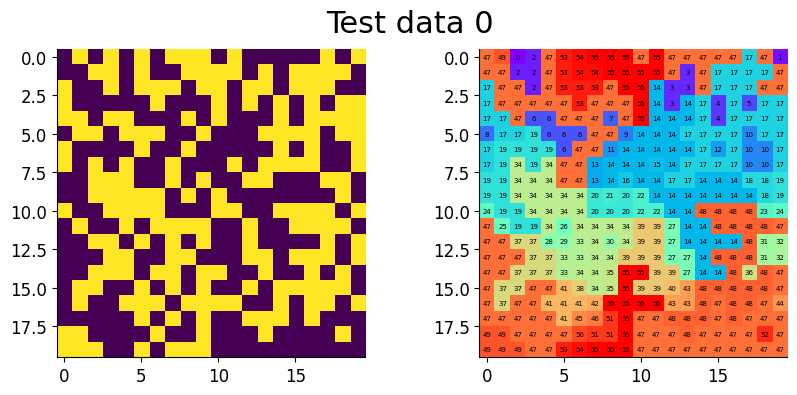

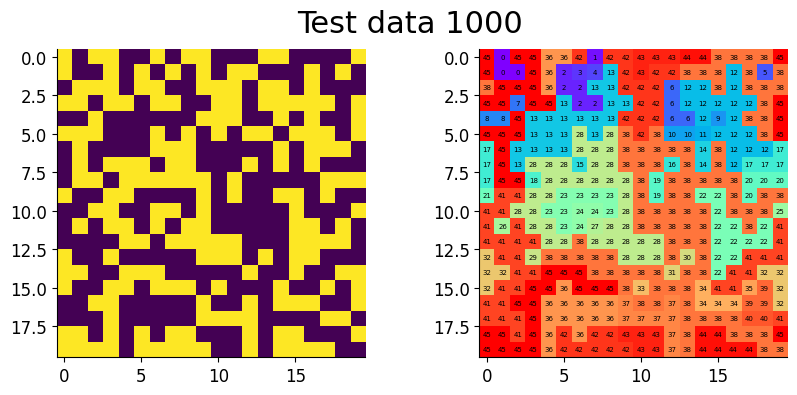

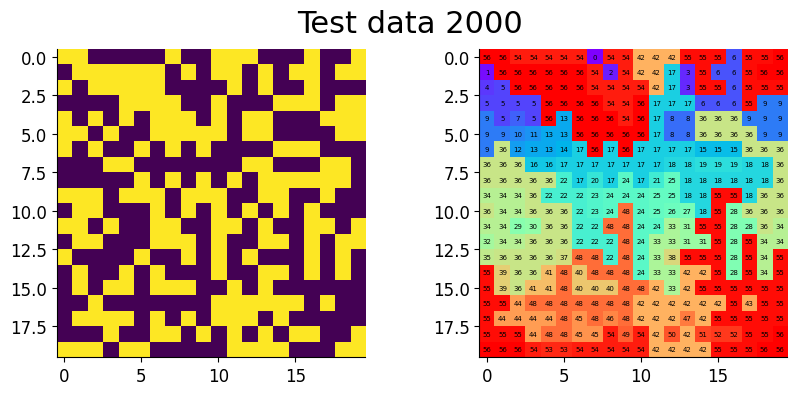

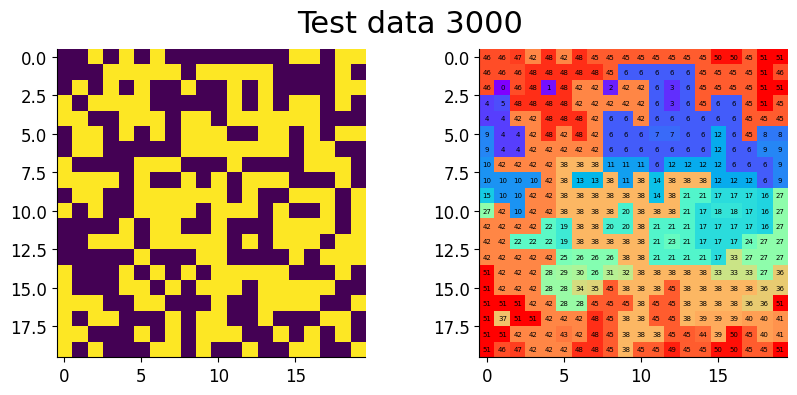

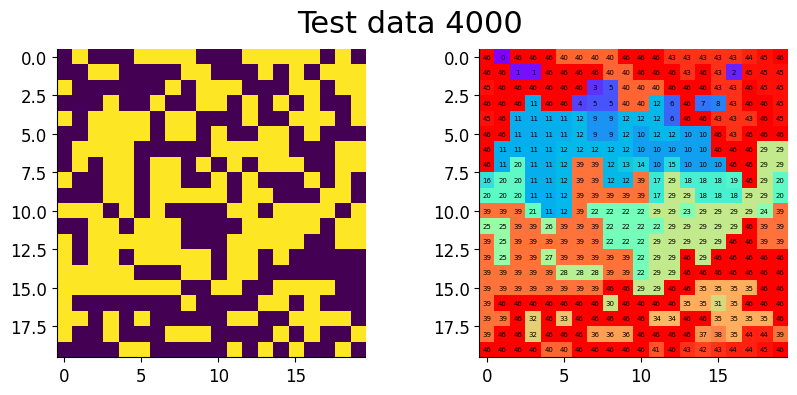

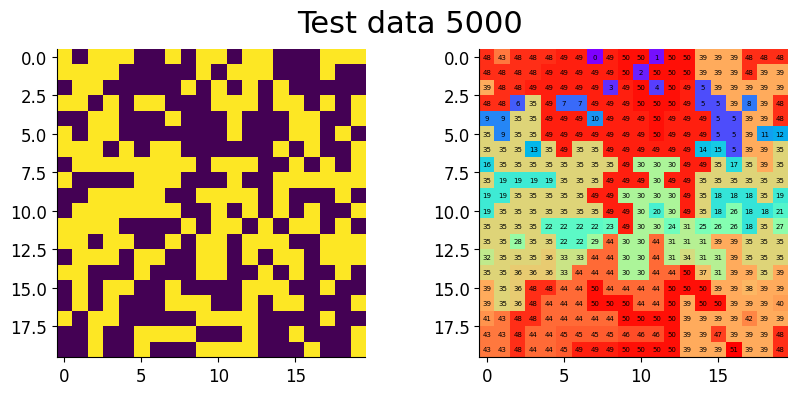

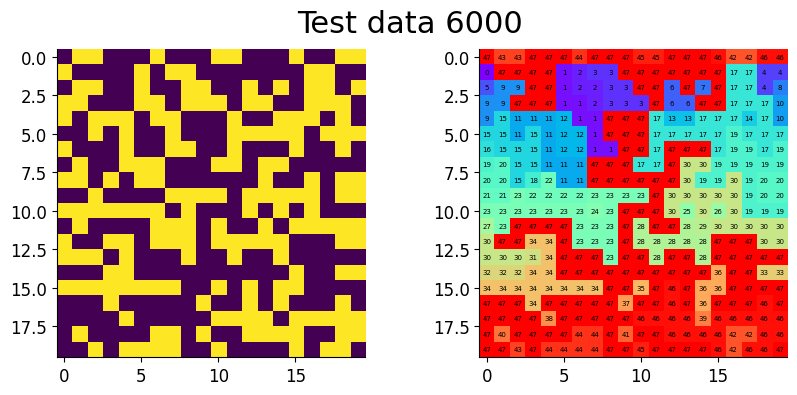

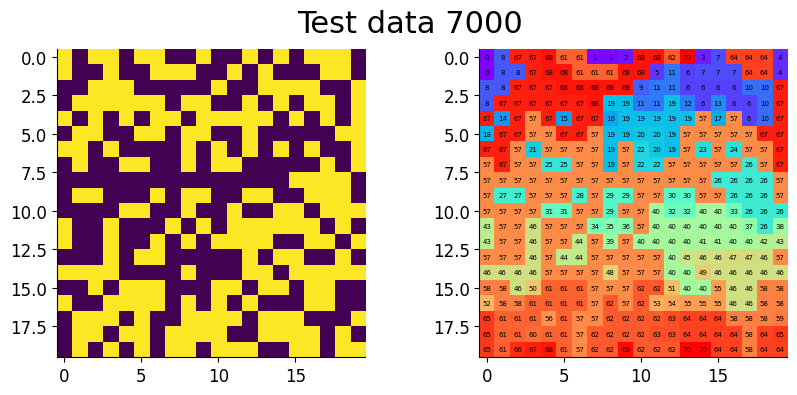

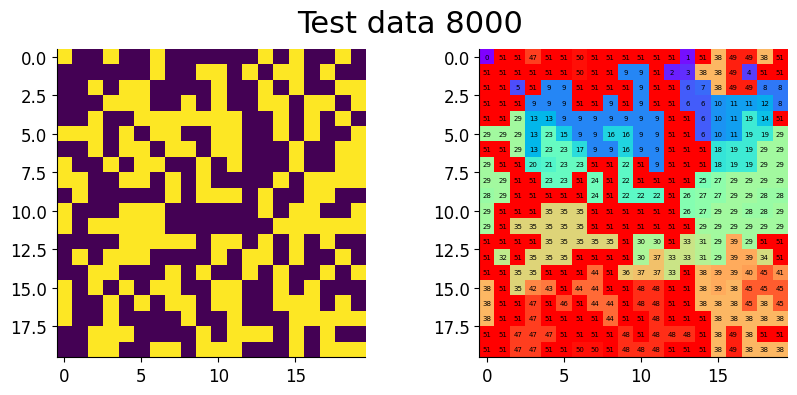

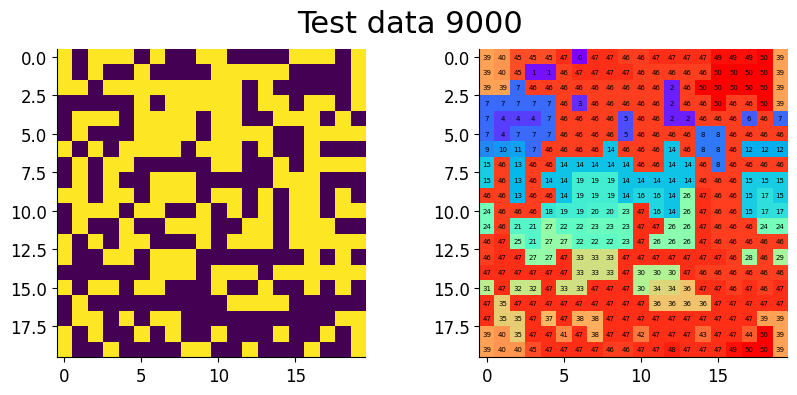

In [ ]:
# T >> T_c
config2 = create_initial_config(20)
for i in range(10000):
  metropolis_single_update(config2,1000)
  labels2 = get_labels(config2)
  if i % 1000 == 0:
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1.imshow(config2)
    ax2.imshow(labels2, cmap="rainbow")
    fig.suptitle(f"Test data {i}", fontsize=22)
    for i in range(len(config2)):
      for j in range(len(config2)):
        ax2.text(j, i, int(labels2[i, j]), ha="center", va="center", color="black", fontsize=5)

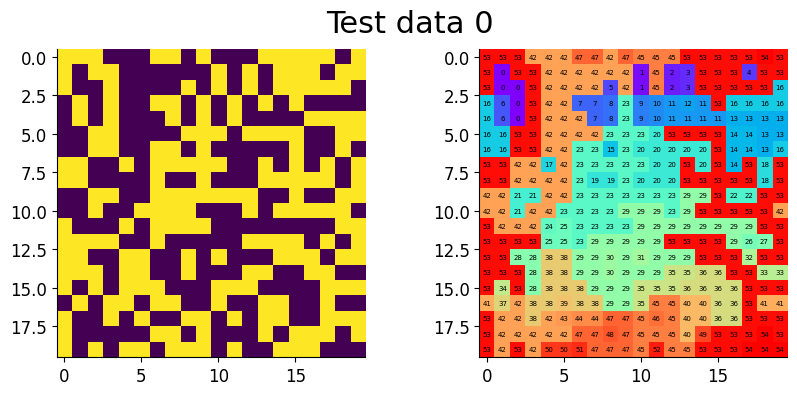

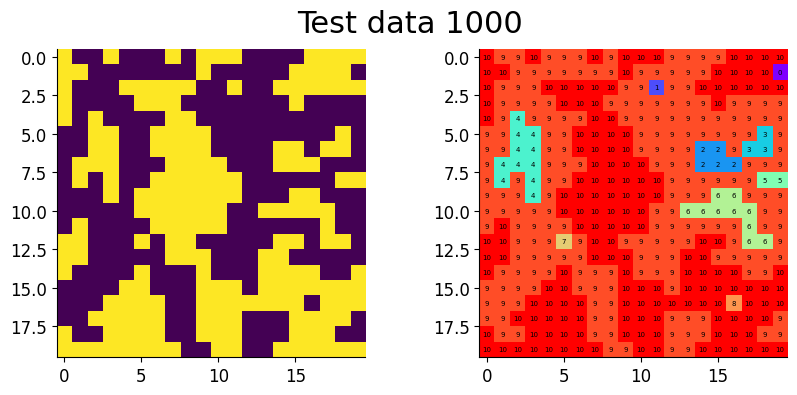

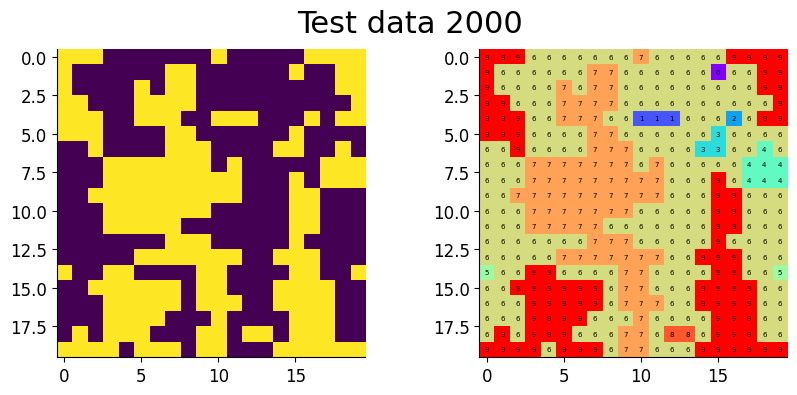

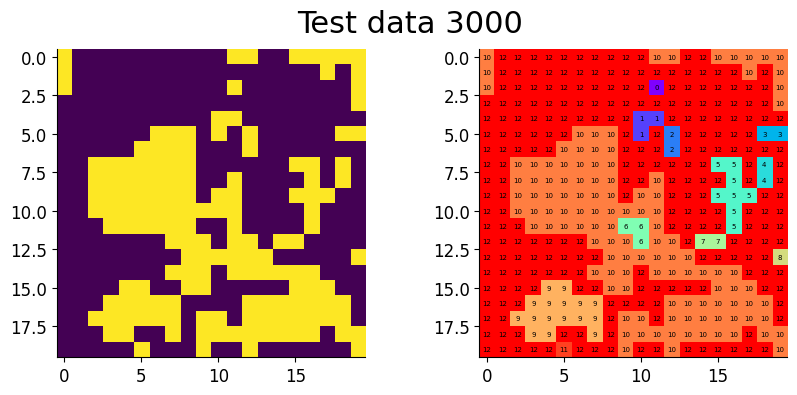

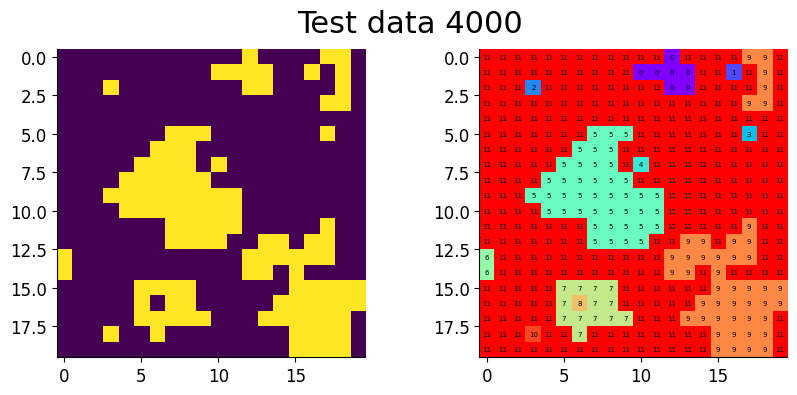

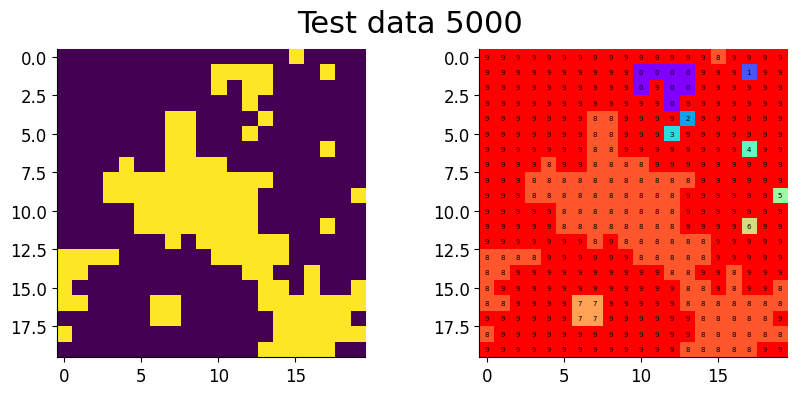

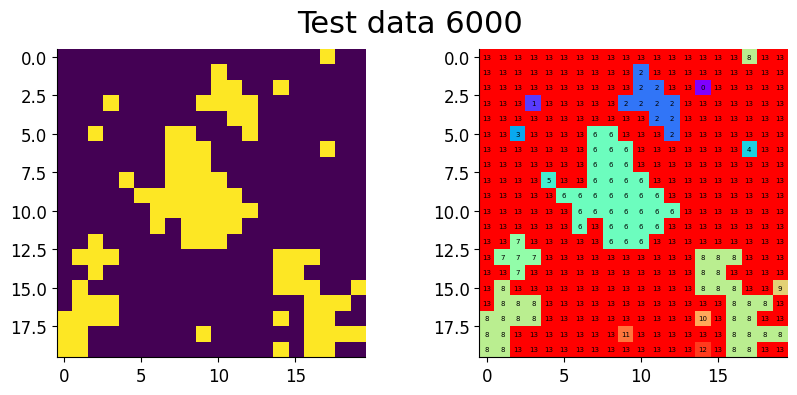

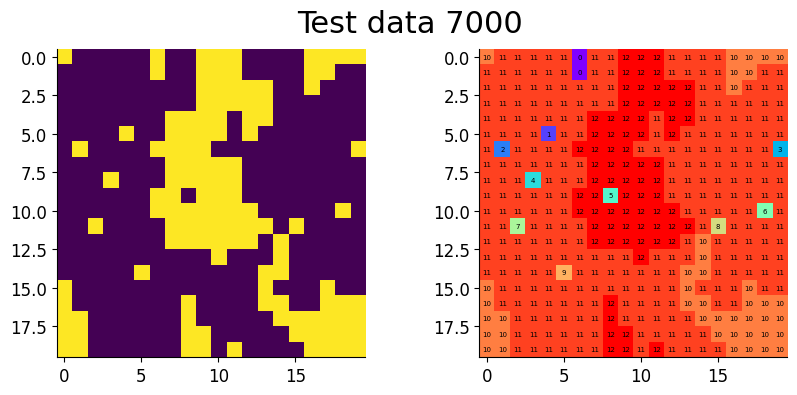

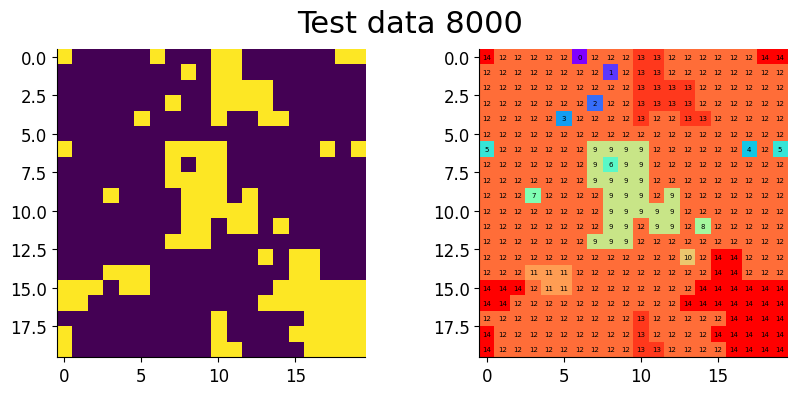

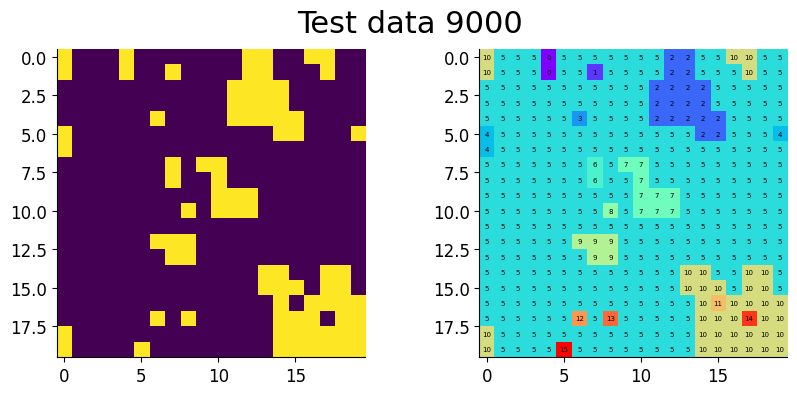

In [ ]:
# T = T_c
config2 = create_initial_config(20)
for i in range(10000):
  metropolis_single_update(config2,T_c)
  labels2 = get_labels(config2)
  if i % 1000 == 0:
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1.imshow(config2)
    ax2.imshow(labels2, cmap="rainbow")
    fig.suptitle(f"Test data {i}", fontsize=22)
    for i in range(len(config2)):
      for j in range(len(config2)):
        ax2.text(j, i, int(labels2[i, j]), ha="center", va="center", color="black", fontsize=5)

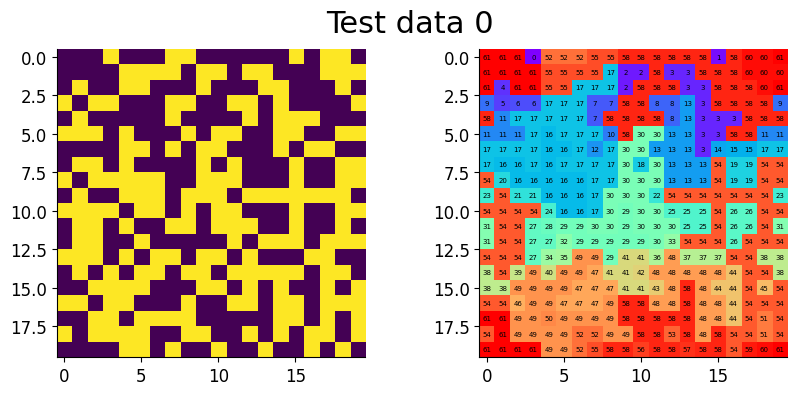

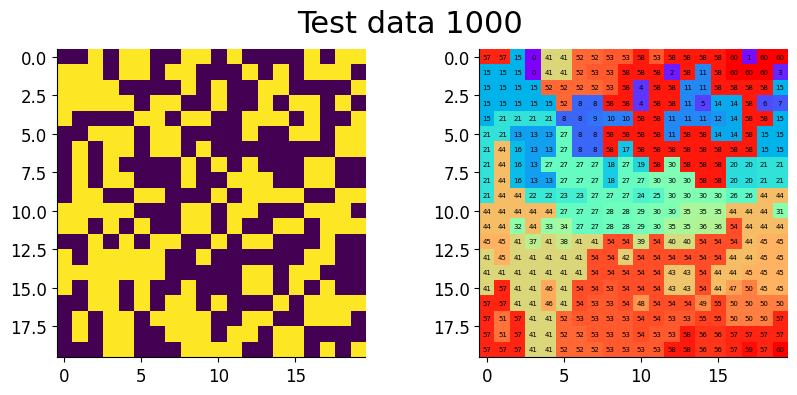

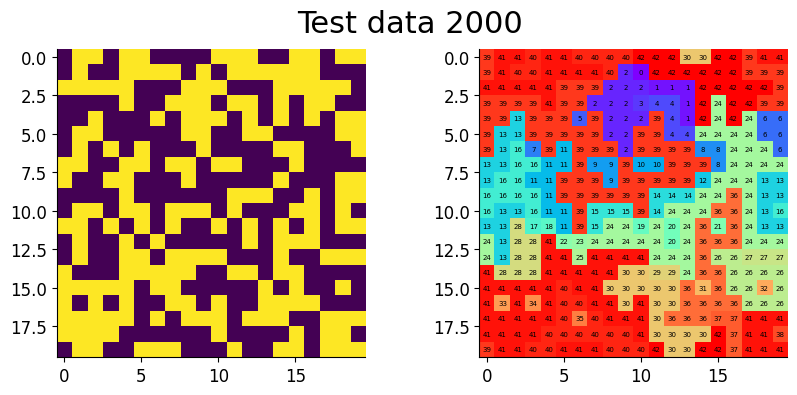

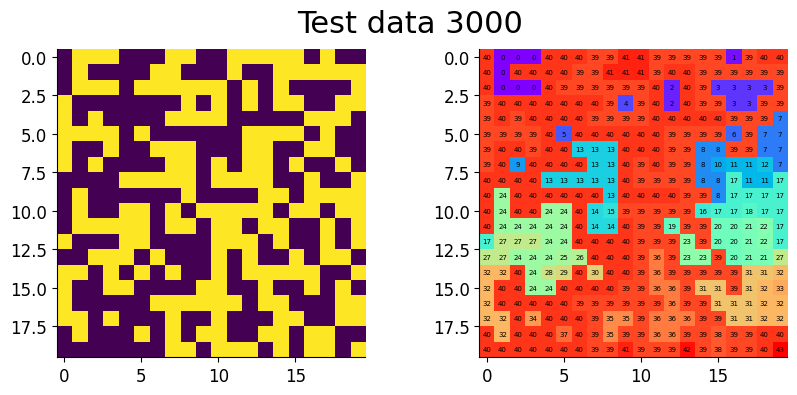

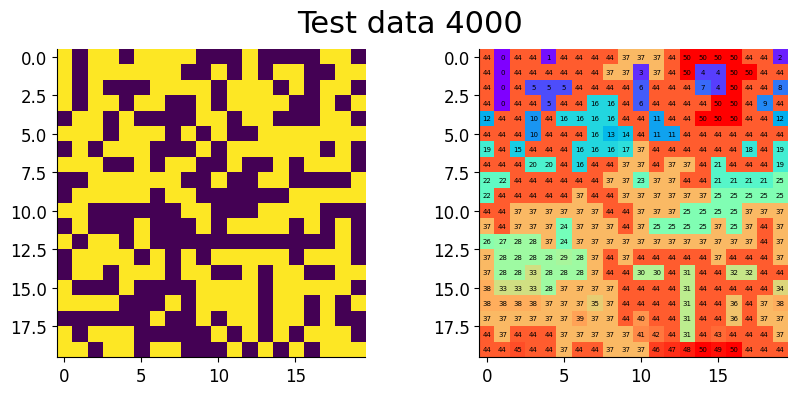

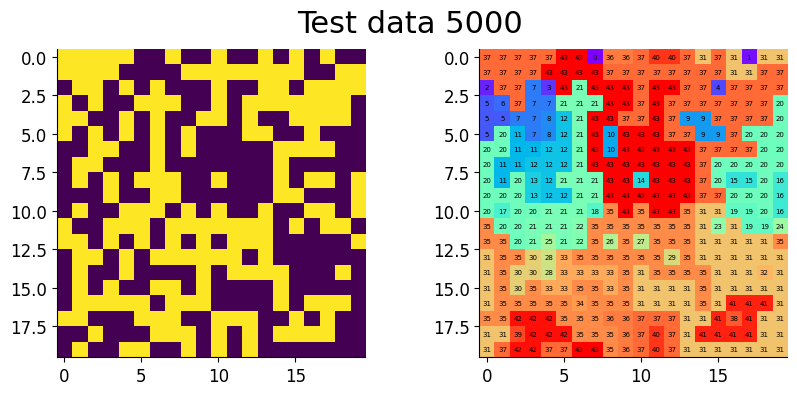

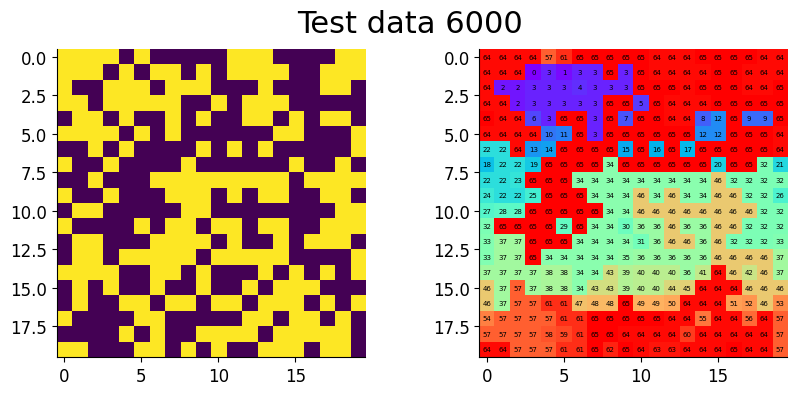

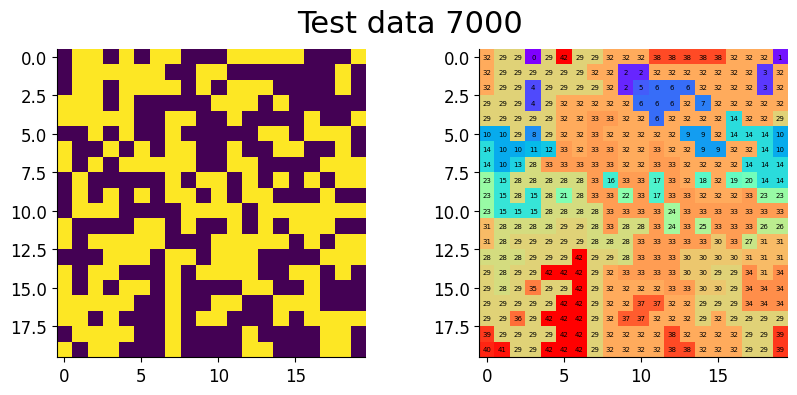

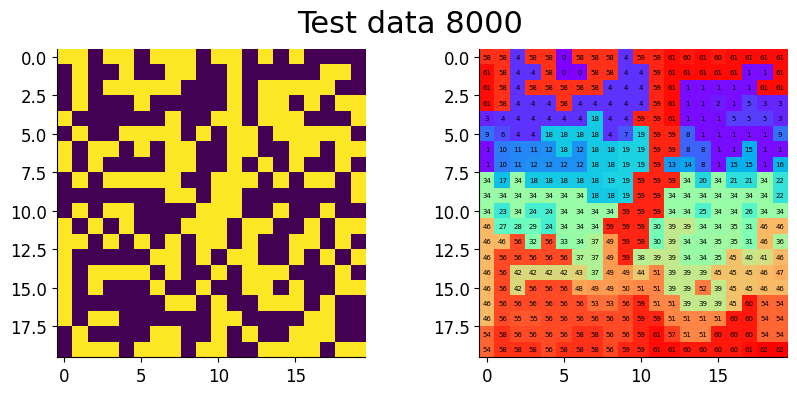

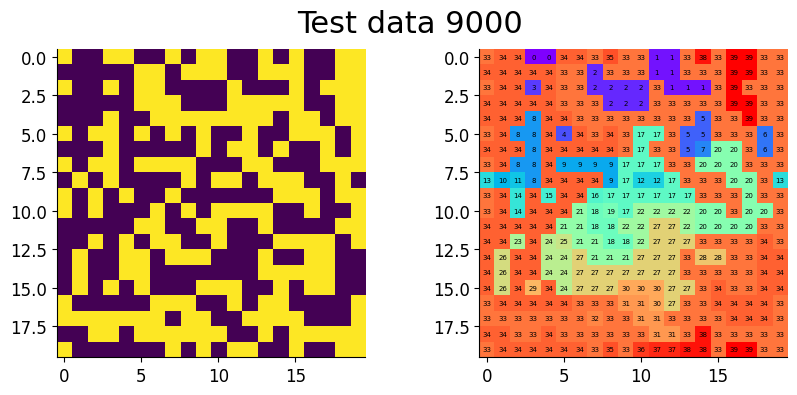

In [ ]:
# T << T_c
config2 = create_initial_config(20)
for i in range(10000):
  metropolis_single_update(config2,-1000)
  labels2 = get_labels(config2)
  if i % 1000 == 0:
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1.imshow(config2)
    ax2.imshow(labels2, cmap="rainbow")
    fig.suptitle(f"Test data {i}", fontsize=22)
    for i in range(len(config2)):
      for j in range(len(config2)):
        ax2.text(j, i, int(labels2[i, j]), ha="center", va="center", color="black", fontsize=5)

### Exercise 2.16
Compute the cluster size distribution and the average cluster size at different times, and graph them versus time (use a log-log scale). For a very large system, it is expected that $\langle L(t) \rangle \sim t^{1/2}$. If the curve is noisy you can average over different statistically identical realizations of the same process.


In [ ]:
config3 = create_initial_config(20)
avg_sizes = []
# T >> T_c
for i in range(1000):
  metropolis_single_update(config3, 1000)
  labels3 = get_labels(config3)
  sizes3 = get_sizes(labels3)
  avg_sizes.append(sum(sizes3/len(sizes3)))
# T << T_c
for i in range(9000):
  metropolis_single_update(config3, 0.01)
  labels3 = get_labels(config3)
  sizes3 = get_sizes(labels3)
  avg_sizes.append(sum(sizes3/len(sizes3)))

time = [i for i in range(10000)]

<ipython-input-47-f3046deafe49>:2: RuntimeWarning: divide by zero encountered in power
  return a * np.power(x, b)


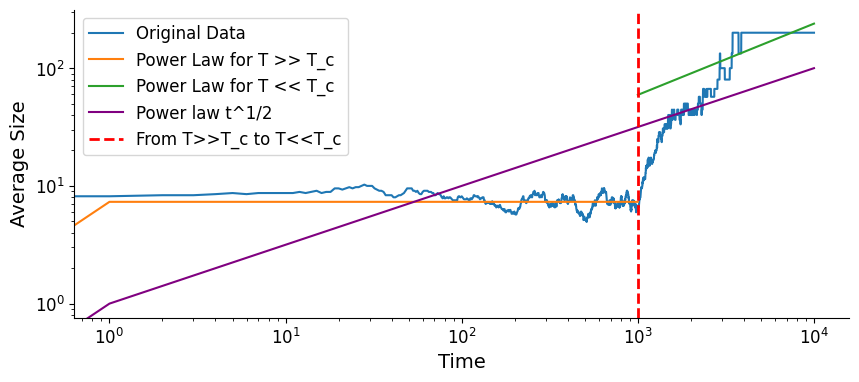

In [ ]:
def power_law(x, a, b):
    return a * np.power(x, b)

params_high, _ = curve_fit(power_law, time[:1000], avg_sizes[:1000])
params_low, _ = curve_fit(power_law, time[1000:], avg_sizes[1000:])

fig, ax1 = plt.subplots(1, 1, figsize=(10,4))
ax1.plot(time, avg_sizes, label='Original Data')
ax1.plot(time[:1000], power_law(time[:1000], *params_high), label='Power Law for T >> T_c')
ax1.plot(time[1000:], power_law(time[1000:], *params_low), label='Power Law for T << T_c')
ax1.plot(time, power_law(time, 1, 1/2), label='Power law t^1/2', c='purple')
ax1.axvline(1000, c='red', lw=2, ls='--', label="From T>>T_c to T<<T_c")

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Time")
ax1.set_ylabel("Average Size")
ax1.legend()
plt.show()

### Exercise 2.17

Use the energy as a measure of the total length of the surface between spin up and spin down regions. Plot this length as a function of time in a log-log plot.

In [ ]:
N = 100
config4 = create_initial_config(N)
lengths = []
T = 1000
for i in range(1000):
  metropolis_single_update(config4, T)
  E = get_energy(config4)
  L = E/2+N
  lengths.append(L)

for i in range(9000):
  metropolis_single_update(config4, 0.01)
  E = get_energy(config4)
  L = E/2+N
  lengths.append(L)

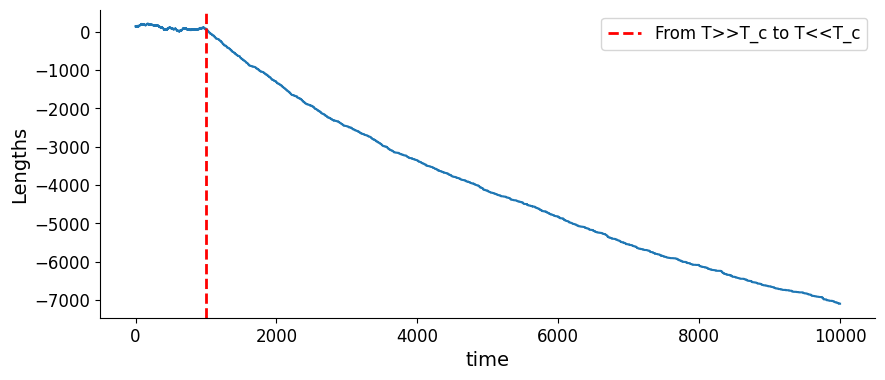

In [ ]:
t = [i for i in range(10000)]
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.plot(t, lengths)
ax.axvline(1000,c='red', lw=2, ls='--', label="From T>>T_c to T<<T_c")
ax.set_xlabel("time")
ax.set_ylabel("Lengths")
ax.legend()

# 2.C Model for segregation

We now study here the Schilling model for urban segregation introduced in

Schelling, Thomas C. (1971). "Dynamic models of segregation". The Journal of Mathematical Sociology. Informa UK Limited. 1 (2): 143–186. doi:10.1080/0022250x.1971.9989794
(see also https://arxiv.org/abs/1104.1971 for review of the different variants of the model).

Here we will consider a square lattice (LxL) representing a city whose cells can be occupied by individuals belonging two different groups A and B or be empty. We can define a variable $\sigma_i$ which is equal to 1 if the individual in i belongs to the group A, to -1 if it belongs to B and 0 if the site is empty.

The rule of the model is as follows: each individual is happy if the neighborhood is prevalently composed by members of the same group. We define the neighborhood of the site i by the 8 adjacent lattice sites
ad shown in the figure:

![image.png](attachment:b12c5ed1-3bbf-4333-83f0-53768c8efe03.png)

Individuals are satisfied if the fraction of neighbors belonging to their own group is larger than a threshold $B_0$. If they are not satisfied they will move to another location.  


### Exercise 2.18

Write a code to perform a Monte Carlo simulation of the Schelling model using a random update algorithm. At each time step:
- 1 pick a site at random
- 2 check the fraction of neighbors B belonging to the same group ad the individual in i.
- 3 if $B<B_0$ pick at random an empty site in the latteice and "move" the individual there.
- 4 go back to 1

In [ ]:
def get_neighbours(matrix, i, j):
    rows, cols = matrix.shape
    neighbours = []
    for x in range(max(0, i-1), min(rows, i+2)):
        for y in range(max(0, j-1), min(cols, j+2)):
            if (x != i or y != j):
                neighbours.append(matrix[x, y])
    return neighbours

def monte_carlo(matrix, b0, max_attempts=1000):
    rows, cols = matrix.shape
    attempt = 0
    while attempt < max_attempts:
        while True:
            i, j = random.randint(0, rows-1), random.randint(0, cols-1)
            if matrix[i, j] != 0:
                break

        neighbours = get_neighbours(matrix, i, j)
        count_same_value = sum(1 for neighbour in neighbours if neighbour == matrix[i, j])
        fraction = count_same_value / len(neighbours)

        if fraction < b0:
            zero_indices = np.argwhere(matrix == 0)
            if len(zero_indices) > 0:
                zero_index = random.choice(zero_indices)
                matrix[i, j], matrix[zero_index[0], zero_index[1]] = matrix[zero_index[0], zero_index[1]], matrix[i, j]
                return matrix
        attempt += 1

    return matrix

In [ ]:
config = np.array([[1, -1, 0, 1, -1, 1],
                   [-1, -1, -1, 1, -1, 1],
                   [-1, 0, -1, -1, 0, 1],
                   [0, 1, -1, 1, 1, 1],
                   [-1, 1, -1, 0, 1, -1],
                   [-1, -1, -1, 1, 1, 1]])
print(monte_carlo(config, 0.8))

[[ 1 -1  0  1 -1  1]
 [-1 -1 -1  1 -1  1]
 [-1  0 -1 -1  1  1]
 [ 0  1 -1  0  1  1]
 [-1  1 -1  0  1 -1]
 [-1 -1 -1  1  1  1]]


### Exercise 2.19
Study the dynamics of the Schelling model as a function of the parameter $B_0$. You can set the initial condition at random with 20% of sites empty and 40% each occupied by the two groups.

- run the simulation for some time and plot some representative snapshots of the configurations at different times.

- compute the average cluster size as a function of $B_0$ in the long time limit. Is there segregation or mixing?

- study how the cluster size grows with time. Does it scale as $t^{1/2}$ as in the Ising model?


In [ ]:
def generate_conf(N):
    total_elements = N * N
    num_zeros = int(0.2 * total_elements)
    num_ones = int(0.4 * total_elements)
    num_neg_ones = total_elements - num_zeros - num_ones

    array = np.zeros((N, N), dtype=int)

    ones = 0
    while ones < num_ones:
      i, j = random.randint(0,N-1), random.randint(0,N-1)
      if array[i,j] == 0:
        array[i,j] = 1
        ones +=1

    min_ones = 0
    while min_ones < num_neg_ones:
      i, j = random.randint(0,N-1), random.randint(0,N-1)
      if array[i,j] == 0:
        array[i,j] = -1
        min_ones +=1

    return array

Text(0.5, 0.98, 'Iteration n: 579')

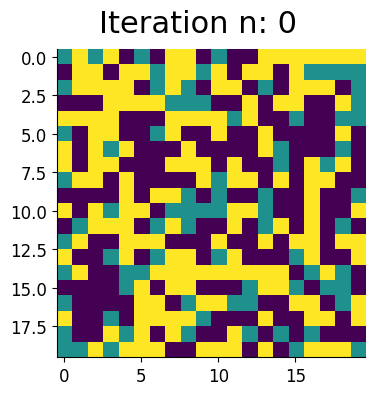

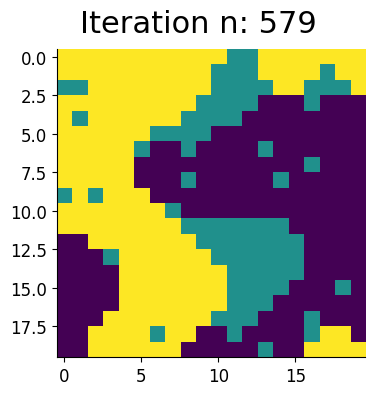

In [ ]:
b0 = 0.4
config = generate_conf(20)
prev_matrix = None

for i in range(10000):
  new_config = monte_carlo(config.copy(), b0)
  if i % 1000 == 0:
    fig, ax1= plt.subplots(1, 1, figsize=(10,4))
    ax1.imshow(config)
    fig.suptitle(f"Iteration n: {i}", fontsize=22)
  if np.array_equal(new_config, prev_matrix):
    break
  prev_matrix = new_config.copy()
  config = new_config

fig, ax1= plt.subplots(1, 1, figsize=(10,4))
ax1.imshow(config)
fig.suptitle(f"Iteration n: {i}", fontsize=22)

In [ ]:
def get_neighbours_indices(i, j, N):
  neighbours = []
  for di in [-1, 0, 1]:
    for dj in [-1, 0, 1]:
      if di == 0 and dj == 0:
        continue
      ni = i + di
      nj = j + dj
      if 0 <= ni < N and 0 <= nj < N:
        neighbours.append((ni, nj))
  return neighbours

def get_labels_8(config):
    N = len(config)
    labels = np.zeros((N, N), dtype=int)
    current_label = 1

    for i in range(N):
        for j in range(N):
            if labels[i][j] == 0:
                labels[i][j] = current_label
                current_label += 1

            current_cluster_label = labels[i][j]
            for ni, nj in get_neighbours_indices(i, j, N):
                if config[i][j] == config[ni][nj]:
                    if labels[ni][nj] == 0:
                        labels[ni][nj] = current_cluster_label
                    else:
                        labels[labels == labels[ni][nj]] = current_cluster_label

    return relabel_clusters(labels)

def relabel_clusters(labels):
    unique_labels = np.unique(labels)
    relabel_map = {label: idx for idx, label in enumerate(unique_labels)}
    relabeled_labels = np.vectorize(relabel_map.get)(labels)
    return relabeled_labels



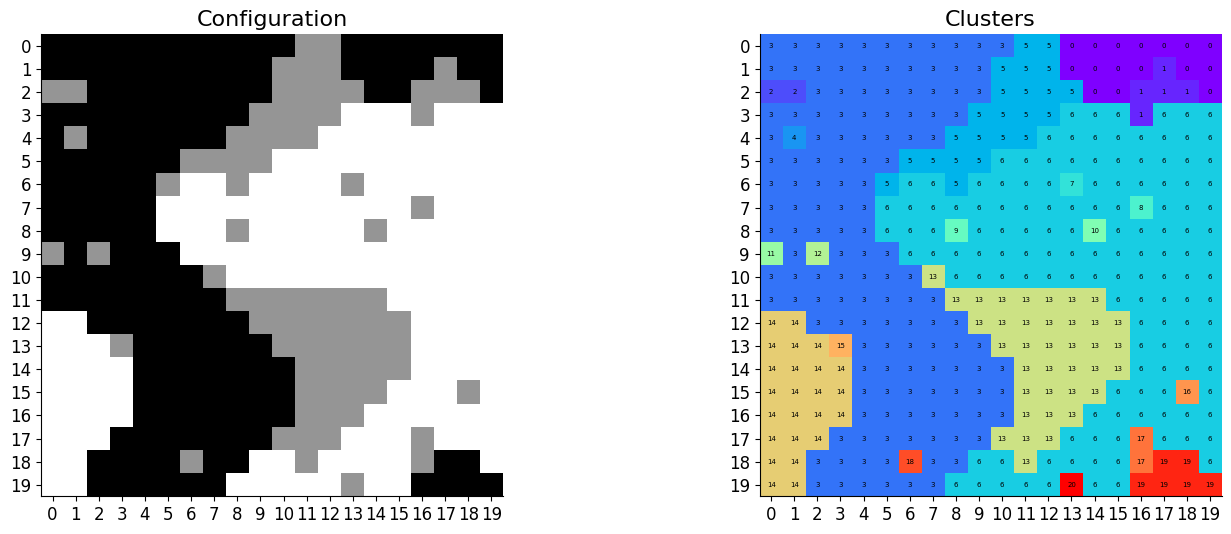

In [ ]:
labels = get_labels_8(config)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,6))
ax1.set_xticks(range(len(config)))
ax1.set_yticks(range(len(config)))
ax2.set_xticks(range(len(config)))
ax2.set_yticks(range(len(config)))
ax1.set_title("Configuration")
ax2.set_title("Clusters")
ax1.imshow(config, cmap="Greys")
ax2.imshow(labels, cmap="rainbow", )
unique_labels = np.unique(labels)
for i in range(len(config)):
  for j in range(len(config)):
    ax2.text(j, i, labels[i, j], ha="center", va="center", color="black", fontsize=5)


In [ ]:
def get_sizes_8(labels):
    flattened_labels = labels.reshape(-1)
    label_counts = Counter(flattened_labels)
    sizes = np.array(list(label_counts.values()))
    return sizes

In [ ]:
B0s = np.linspace(0,1,100)
avarage_sizes = []
for B0 in B0s:
  config_test= generate_conf(20)
  for i in range(10000):
    new_config = monte_carlo(config_test.copy(), B0)
    if np.array_equal(new_config, prev_matrix):
      break
    prev_matrix = new_config.copy()
    config_test = new_config
  labels_test = get_labels_8(config_test)
  sizes_test = get_sizes_8(labels_test)
  avarage_sizes.append(sum(sizes_test)/len(sizes_test))

Text(0, 0.5, 'Avarage cluster sizes')

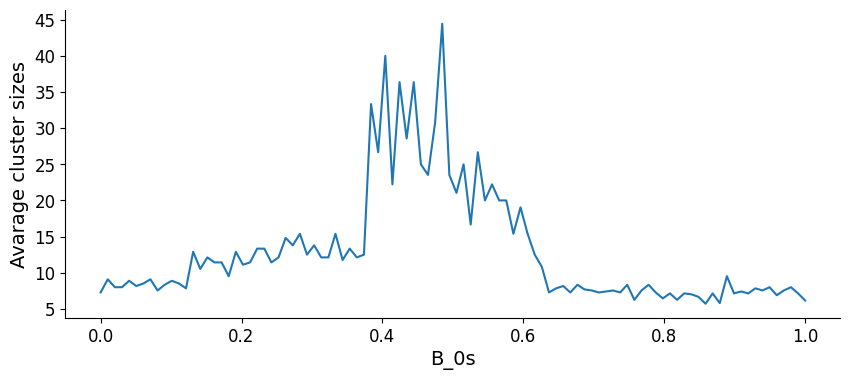

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,4))
ax1.plot(B0s, avarage_sizes)
ax1.set_xlabel("B_0s")
ax1.set_ylabel("Avarage cluster sizes")

We can see that for $B_0$ from 0.4 and 0.6 the avarage cluster size is larger, which means more segregation w.r.t. $B_0$ values bigger than 0.6, where we have more mixing.

In [ ]:
avarage_sizes = []
time =[]
config_test1 = generate_conf(20)
prev_matrix = None
for i in range(10000):
  new_config = monte_carlo(config_test1.copy(), 0.4)
  labels_test = get_labels_8(new_config)
  sizes_test = get_sizes_8(labels_test)
  avarage_sizes.append(sum(sizes_test)/len(sizes_test))
  time.append(i)
  prev_matrix = new_config.copy()
  config_test1 = new_config

In [ ]:
def power_law(x, a, b):
    return a * np.power(x, b)

params, _ = curve_fit(power_law, time, avarage_sizes)

Params: [11.83830592  0.09467928]


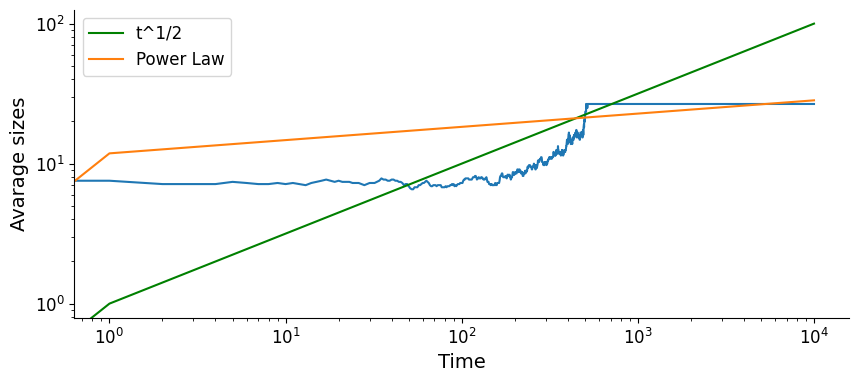

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,4))
ax1.plot(time, avarage_sizes)
ax1.plot(time, np.power(time,1/2), color='green', label='t^1/2')
ax1.plot(time, power_law(time, *params), label='Power Law')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Time")
ax1.set_ylabel("Avarage sizes")
ax1.legend()
print(f"Params: {params}")

We can see that in this case the cluster size grows with time does not scale as $t^{1/2}$ as in the Ising model, but as $12+t^{0.95}$